En este programa haremos adquisición de datos desde el Arduino, el cual tiene conectado a una de sus entradas análogas (A0) un potenciómetro. A su vez, esta señal pasa por un ADC el cual mapea nuestro voltaje de entrada ($0 - 5 [V]$) con una resolución de $2^{10}$ bits, haciendo que tengamos una lectura entre 0 y 1023 valores diferentes. 

Lo primero que debemos hacer para realizar la conexión y adquirir datos es importar las librerías necesarias:

In [1]:
%matplotlib notebook

import serial
import numpy as np
import sys
from serial.tools.list_ports import comports
from matplotlib import pyplot as plt
from time import time

El siguiente paso es detectar dónde está conectado el Arduino. Para ello usamos la siguiente función:

In [2]:
def dump_port_list():
    """ 
    Función que imprime en pantalla todos los puertos disponibles, para así ver dónde está conectado nuestro Arduino
    """
    if comports:
        sys.stderr.write('\n--- Puertos disponibles:\n')
        for port, desc, hwid in sorted(comports()):
            sys.stderr.write('--- %-20s %s\n' % (port, desc))

In [3]:
dump_port_list()


--- Puertos disponibles:
--- COM3                 Arduino Uno (COM3)


Una vez que ya conocemos el puerto al cual nuestro Arduino está conectado, hacemos la conexión usando las librería Pyserial. La siguiente línea de código DEBE ser modificada en caso de que el puerto seleccionado no sea el que corresponda. Nota

In [4]:
# Seleccionamos el puerto COM3 con un baudrate = 115200. Es importante que este baudrate COINCIDA con el que tiene el
# Arduino cargado en su memoria
ser = serial.Serial('COM3', 115200)

A continuación inicializamos las variables utilizadas durante la adquisición de datos. Además, seteamos las opciones para el gráfico que se mostrará. En la siguiente parte del código comienza la adquisición efectiva de datos. Entramos en un loop que durará duration segundos, es decir, 10 segundos. Una vez terminado este tiempo, termina la adquisición y se grafica todo lo obtenido en una nueva figura. Se grafica en forma de animación todos los datos capturados

<IPython.core.display.Javascript object>


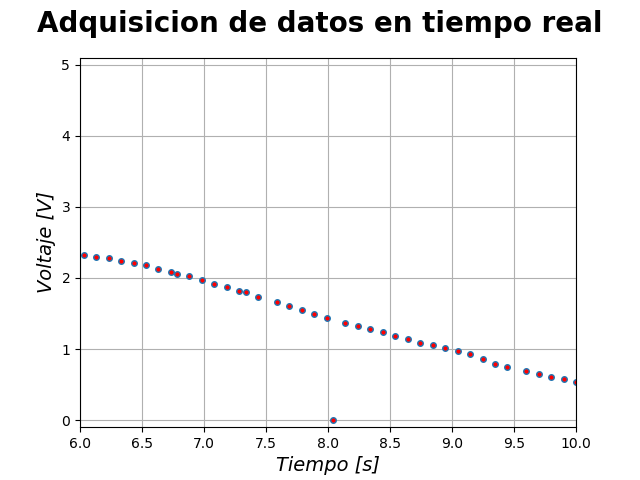

C:\Users\duran\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
# Comenzamos un gráfico animado
plt.ion() 
# Inicialización de variables globales que contendrán los datos
start_time = time()
timepoints = []
ydata = []
yrange = [-0.1,5.1]
# Segundos que serán visualizados a la vez
view_time = 4
# Duración total que correrá la adquisición antes de finalizar
duration = 10

# Inicialización de parámetros para el primer gráfico (adquisición tiempo real)
fig1 = plt.figure()
fig1.suptitle('Adquisicion de datos en tiempo real', fontsize='20', fontweight ='bold')
plt.xlabel('Tiempo [s]', fontsize ='14', fontstyle ='italic')
plt.ylabel('Voltaje [V]', fontsize ='14', fontstyle ='italic')
plt.axes().grid(True)
line1, = plt.plot(ydata, marker ='o', markersize = 4, linestyle = 'none', markerfacecolor = 'red')
plt.ylim(yrange)
plt.xlim([0,view_time])

# Limpia cualquier dato que pudiera estar en el búfer serial 
ser.flushInput()
# Inicialización variable que llevará control del tiempo que corre la adquisición
run = True
while run:
    # Reinicia el búfer serial
    ser.reset_input_buffer()
    # Lee el dato entregado por Arduino de formas erial
    data = ser.readline().split(' ')
    
    # Dado que a veces los datos son solo basura, "intentamos" realizar el gráfico, de otra forma, no hacemos nada. 
    try:
        # Guardamos todos los datos obtenidos en ydata
        ydata.append(float(data[0]) * 5.0 / 1024)
        # Agregamos el tiempo actual transcurrido
        #timepoints.append(time()-start_time)
        timepoints.append(time()-start_time)
        # Obtenemos el último elemento de la lista (o sea, el tiempo actual)
        current_time = timepoints[-1]
        
        # Actualizamos gráfico con los nuevos datos
        line1.set_xdata(timepoints)
        line1.set_ydata(ydata)
        
        # Deslizamos el gráfico si excedimos la cantidad de view_time segundos. Actualizamos eje x.
        if current_time > view_time:
            plt.xlim([current_time - view_time,current_time])
            
        # Cuando el tiempo se acabe (se alcance duration), salimos del loop y dejamos de adquirir datos
        if timepoints[-1] > duration: 
            run = False
    
    # Si por alguna razón detecta un error en la adquisición de datos, simplemente lo ignoramos y hacemos nada. 
    except: 
        pass
    
    # Se actualiza el gráfico
    fig1.canvas.draw()

Ahora graficamos todos los datos capturados desde 0 hasta duration y finalmente se cierra el puerto.

<IPython.core.display.Javascript object>


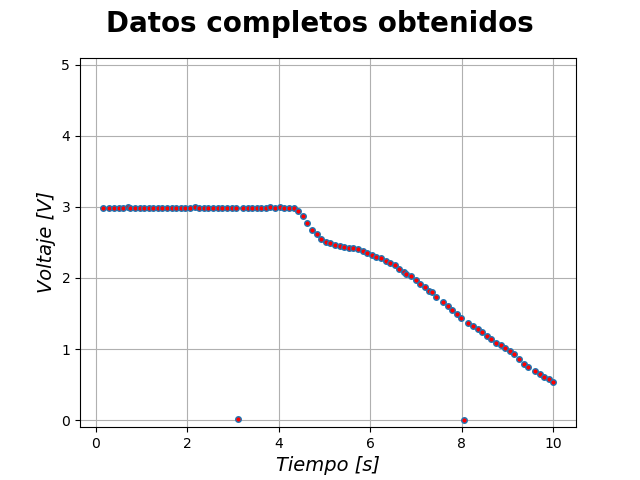

In [6]:
# Gráfico que contendrá todos los datos obtenidos
fig2 = plt.figure()
fig2.suptitle('Datos completos obtenidos', fontsize = '20', fontweight = 'bold')
plt.xlabel('Tiempo [s]', fontsize = '14', fontstyle = 'italic')
plt.ylabel('Voltaje [V]' , fontsize= '14', fontstyle = 'italic')
plt.axes().grid(True)

plt.plot(timepoints, ydata, marker= 'o',markersize = 4,linestyle = 'none',markerfacecolor = 'red')
plt.ylim(yrange)
fig2.show()
# Cerramos el puerto del dispositivo
ser.close()